In [249]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as datetime

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [250]:
df = pd.read_csv('C:\\Users\\jj_do\\OneDrive\\Documents\\Data Analytics\\PycharmProjects\\UK_energy.csv')
df.head()

,date,MW,settlement_period
0,2009-01-01,37910,1
1,2009-01-01,38047,2
2,2009-01-01,37380,3
3,2009-01-01,36426,4
4,2009-01-01,35687,5


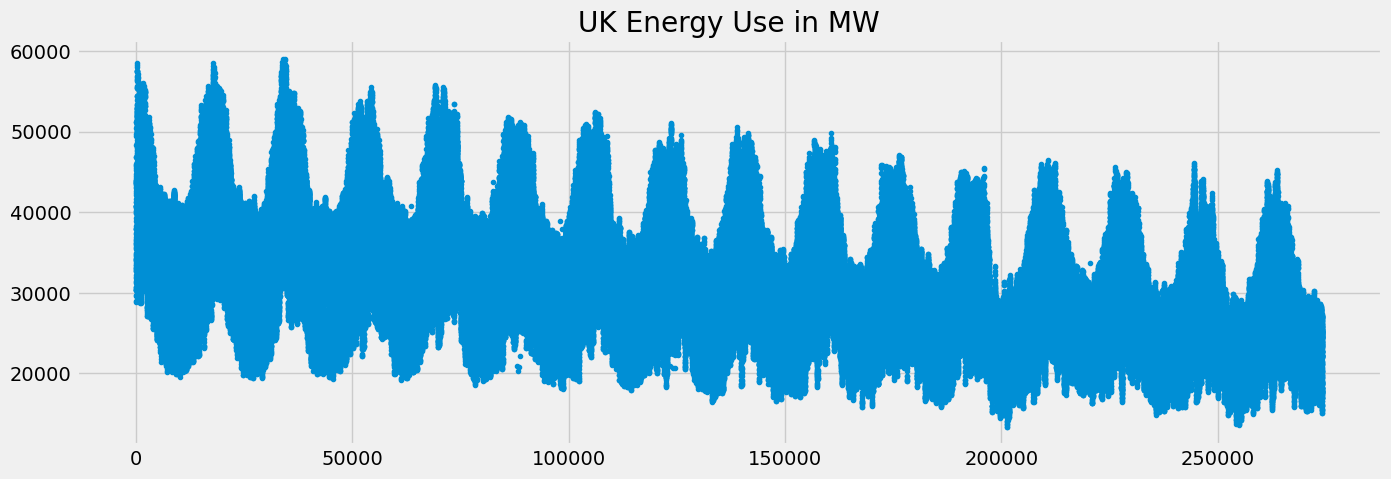

In [251]:
df['MW'].plot(style='.',
        figsize=(15, 5),
        color=color_pal[0],
        title='UK Energy Use in MW')
plt.show()

In [252]:
# Maximum settlement_period in dataset is 48, therefore will remove any outliers that are above 48
df.drop(index=df[df["settlement_period"] > 48].index, inplace=True)

In [253]:
# Apply lambda function to turn settlement period into hours.
# Settlement period equal to 0 corresponds with 00:00:00 and each
# settlement period adds 30 minutes until settlement period 48, which
# corresponds with 23:30:00
df["period_hour"] = (df["settlement_period"]).apply(
    lambda x: str(datetime.timedelta(hours=(x - 1) * 0.5))
)

df.loc[df["period_hour"] == "1 day, 0:00:00", "period_hour"] = "0:00:00"

# Move the new column
column_to_move = df.pop("period_hour")
df.insert(2, "period_hour", column_to_move)

df.head()

,date,MW,period_hour,settlement_period
0,2009-01-01,37910,0:00:00,1
1,2009-01-01,38047,0:30:00,2
2,2009-01-01,37380,1:00:00,3
3,2009-01-01,36426,1:30:00,4
4,2009-01-01,35687,2:00:00,5


In [254]:
# Combine 'period_hour' with datetime
df["date"] = pd.to_datetime(
    (df["date"] + " " + df["period_hour"])
)
df.head()

,date,MW,period_hour,settlement_period
0,2009-01-01 00:00:00,37910,0:00:00,1
1,2009-01-01 00:30:00,38047,0:30:00,2
2,2009-01-01 01:00:00,37380,1:00:00,3
3,2009-01-01 01:30:00,36426,1:30:00,4
4,2009-01-01 02:00:00,35687,2:00:00,5


In [255]:
df = df.set_index('date')
df.index = pd.to_datetime(df.index)

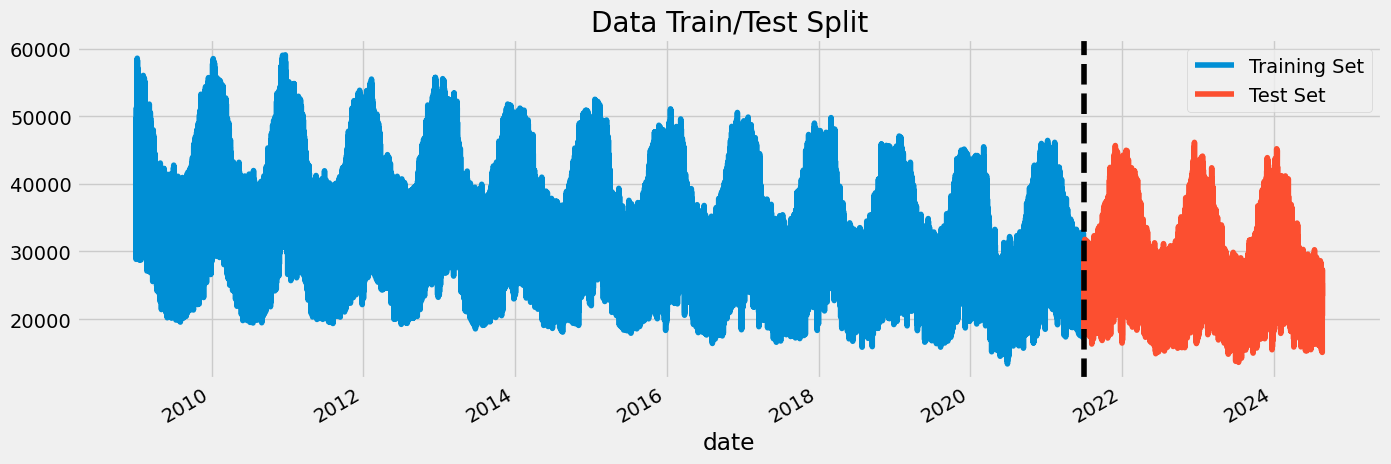

In [256]:
# Using subpltots to seperate train and test data
train = df.loc[df.index < '07-01-2021']
test = df.loc[df.index >= '07-01-2021']

fig, ax = plt.subplots(figsize=(15, 5))
train['MW'].plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test['MW'].plot(ax=ax, label='Test Set')
ax.axvline('07-01-2021', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

<Axes: xlabel='date'>

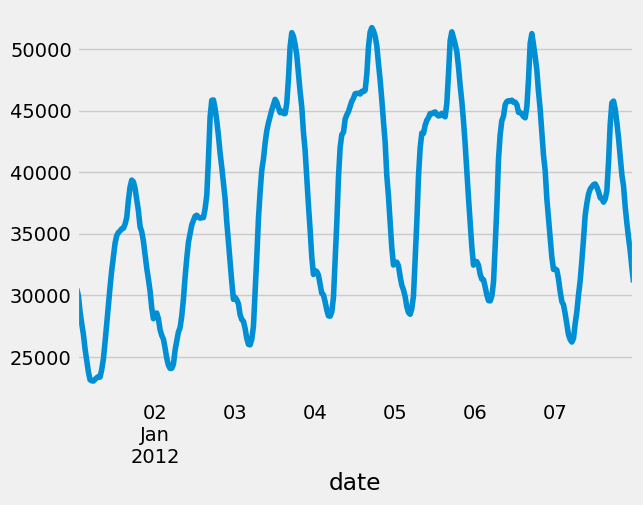

In [257]:
# Energy usage over a week in the UK in MW
df['MW'].loc[(df.index > '01-01-2012') & (df.index < '01-08-2012')].plot()

## Create Features

In [259]:
def create_features(df):
    """Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    return df

df = create_features(df)

In [260]:
df.head()

,MW,period_hour,settlement_period,hour,day_of_week,quarter,month,year,dayofyear
date,,,,,,,,,
2009-01-01 00:00:00,37910,0:00:00,1,0,3,1,1,2009,1
2009-01-01 00:30:00,38047,0:30:00,2,0,3,1,1,2009,1
2009-01-01 01:00:00,37380,1:00:00,3,1,3,1,1,2009,1
2009-01-01 01:30:00,36426,1:30:00,4,1,3,1,1,2009,1
2009-01-01 02:00:00,35687,2:00:00,5,2,3,1,1,2009,1


## Visualise our Feature / Target Relationship

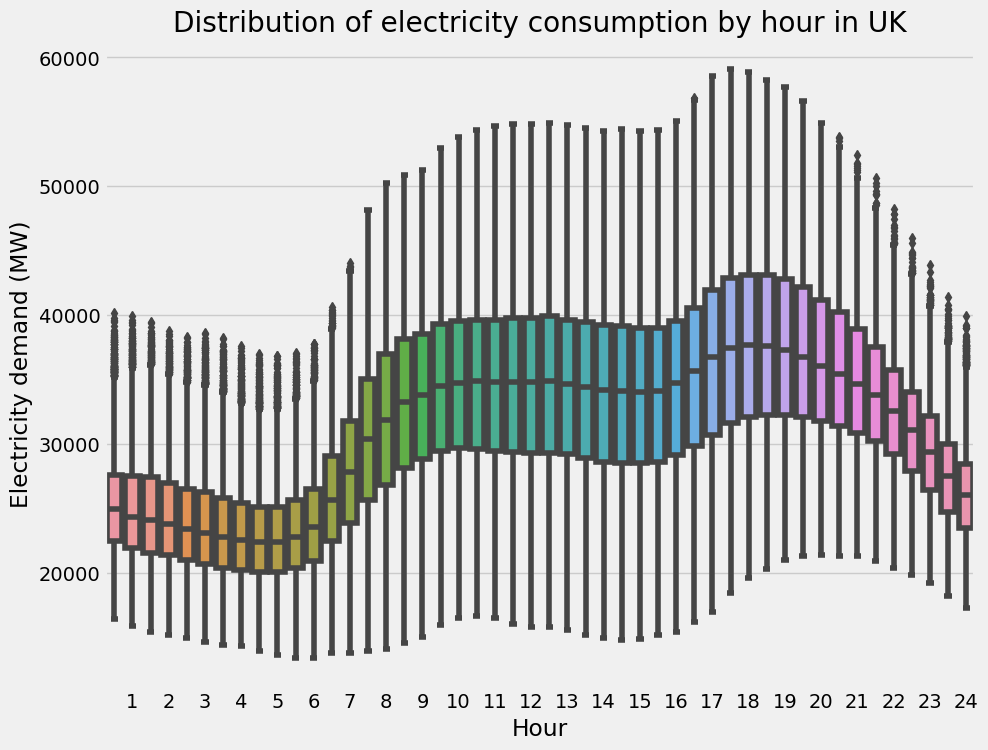

In [262]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="settlement_period", y="MW")
# Reduce the frequency of the xticks and change the labels to be in
# the range [0,24] hours
ax.set_xticks(range(1, 49, 2))
ax.set_xticklabels(range(1, 25))
ax.set_xlabel("Hour")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption by hour in UK");

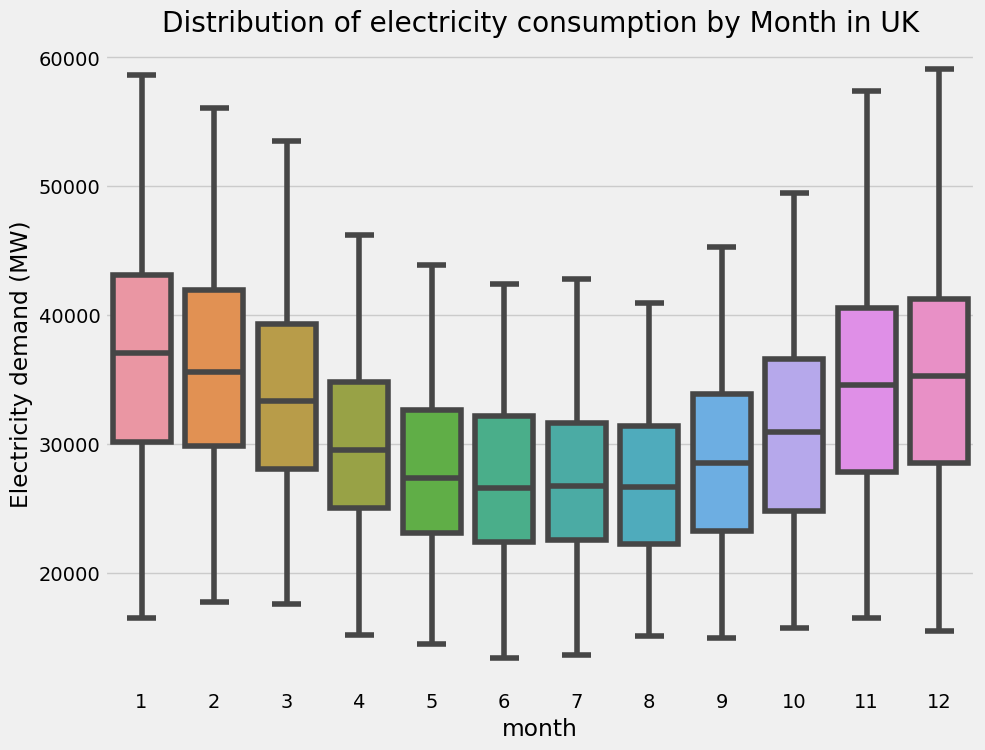

In [263]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x="month", y="MW")
ax.set_xlabel("month")
ax.set_ylabel("Electricity demand (MW)")
ax.set_title("Distribution of electricity consumption by Month in UK");

## Create our Model


In [265]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'day_of_week','quarter', 'month', 'year', 'dayofyear']
TARGET = 'MW'

In [266]:
X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [285]:
# Create our regression model
reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50,
                      learning_rate=0.01)
reg.fit(X_train, y_train,
       eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:7699.06742	validation_1-rmse:8496.22499
[100]	validation_0-rmse:3846.39287	validation_1-rmse:4904.69257
[200]	validation_0-rmse:2541.94849	validation_1-rmse:3723.86670
[300]	validation_0-rmse:2051.71318	validation_1-rmse:3255.55770
[400]	validation_0-rmse:1822.88116	validation_1-rmse:3162.80280
[500]	validation_0-rmse:1702.56432	validation_1-rmse:3152.76016
[593]	validation_0-rmse:1634.41583	validation_1-rmse:3149.32452


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature Importance


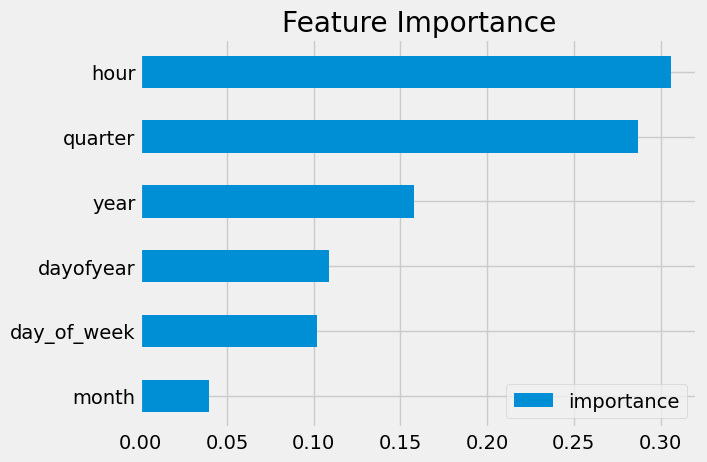

In [292]:
# Shows that hour and quarter were of most importance in creating our model
fi = pd.DataFrame(reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

## Forecast on Test Set with our Trained Model

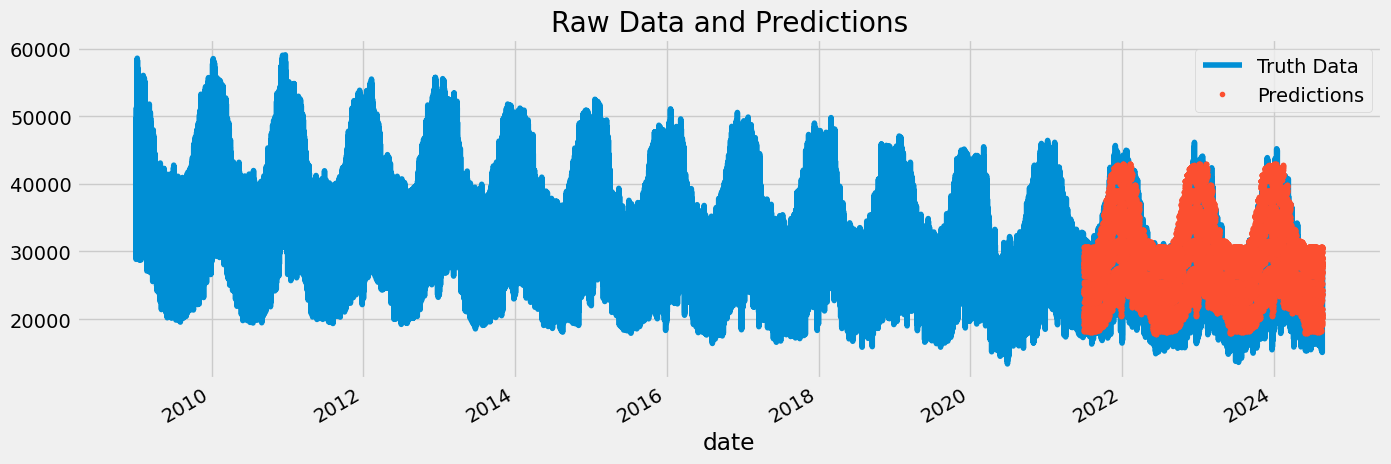

In [311]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['MW']].plot(figsize=(15,5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Data and Predictions')
plt.show()

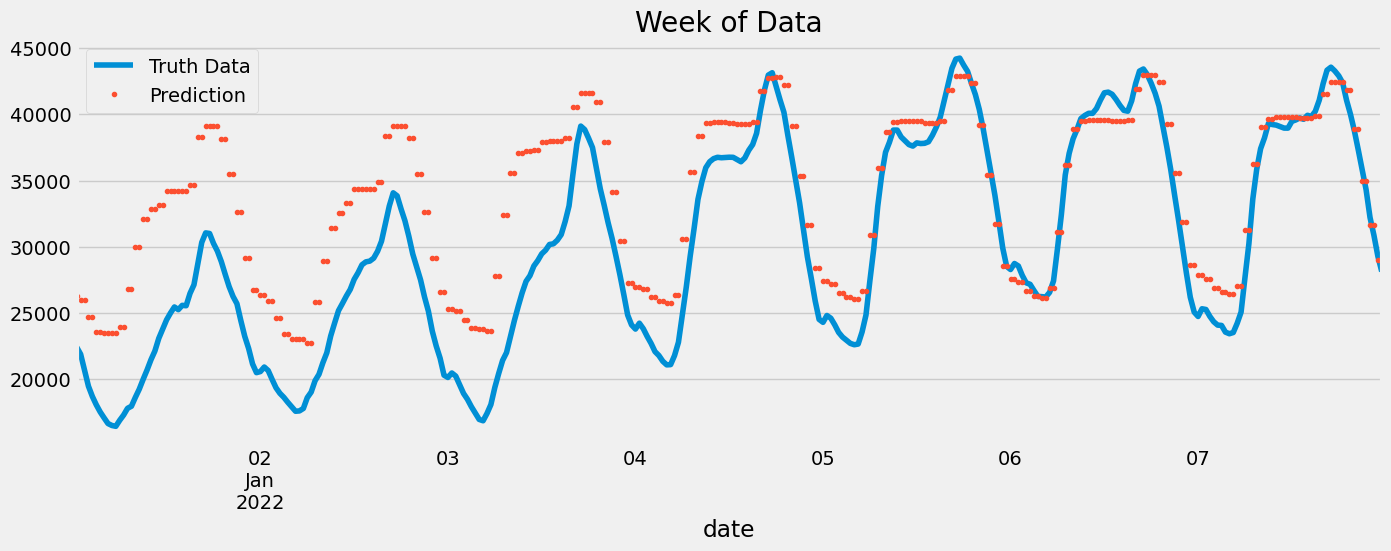

In [315]:
# Look at our predicition on the weekly.
df['MW'].loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')].plot(figsize=(15,5), title='Week of Data')
df['prediction'].loc[(df.index > '01-01-2022') & (df.index < '01-08-2022')].plot(style='.')
plt.legend(['Truth Data', 'Prediction'])
plt.show()